# Calculate constituent strain parameters
This notebook demonstrates how to calculate the constituent strain in a fashion suitable for subsequent fitting of cluster expansions and Monte Carlo simulations. The result will be a file with Redlich-Kister parameters that can be used to quickly evaluate the strain energy for a superlattice with a particular concentration and interface orientation.

Here, the Ag-Cu system will be used as example. This is a cubic system, and the below code relies on cubic symmetry; for non-cubic symmetries, siginificant changes need to be made. For simplicity, we will use ASE's EMT calculator to calculate energy. This should typically be replaced with DFT calculations. The algorithm used here is based on the one outlined by [Ozoliņš et al. (doi: 10.1103/PhysRevB.57.4816)](https://doi.org/10.1103/PhysRevB.57.4816), which in turn was based on [Laks et al. (doi: 10.1103/PhysRevB.46.12587](https://doi.org/10.1103/PhysRevB.46.12587).

In [1]:
from icet.tools.constituent_strain_helper_functions import redlich_kister, redlich_kister_vector
from scipy.optimize import minimize, curve_fit
from ase.build import bulk
from ase.calculators.emt import EMT
import matplotlib.pyplot as plt
import numpy as np

## Extract cohesive energy and equilibrium lattice parameter

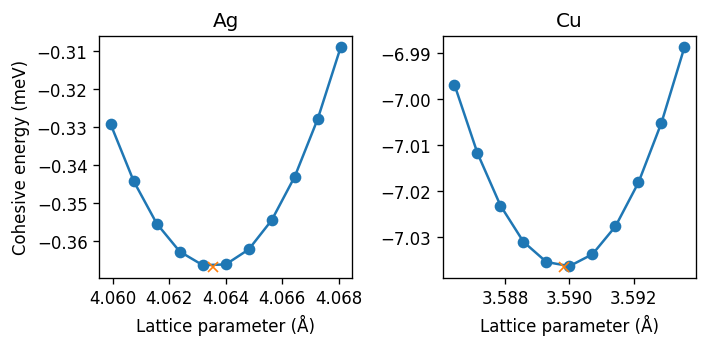

In [2]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3), dpi=120)

elements = ('Ag', 'Cu')
a_guess = {'Ag': 4.064, 'Cu': 3.59}  # We can refine these guesses if they are wrong
a_calculated = {}  # Will hold the calculated equilibrium lattice parameter
E_coh = {}  # Will hold cohesive energies
calc = EMT()

npoints = 11
scales = np.linspace(0.999, 1.001, npoints)
for element_i, element in enumerate(elements):
    
    # Calculate energy for cells with increasing size
    energies = []
    for scale in scales:
        a = a_guess[element] * scale
        structure = bulk(element, a=a, crystalstructure='fcc')
        structure.calc = calc
        energy = structure.get_potential_energy()
        energies.append(energy)
    
    # Find minimum.
    # Can obviously be done in many ways; here we fit a polynomial and search for the minima of the polynomial
    pfit = np.polyfit(a_guess[element] * scales, energies, deg=3)
    poly = np.poly1d(pfit)
    res = minimize(poly, x0=a_guess[element],
                   bounds=[(a_guess[element] * scales[0], a_guess[element] * scales[-1])])
    a_calculated[element] = res.x[0]
    E_coh[element] = poly(res.x[0])
    
    ax = axes[element_i]
    ax.set_title(element)
    conv = 1e3
    ax.plot(a_guess[element] * scales, conv * np.array(energies), '-o')
    ax.set_xlabel('Lattice parameter (Å)')
    
    ax.plot([a_calculated[element]], [conv * E_coh[element]], 'x')

axes[0].set_ylabel('Cohesive energy (meV)') 
plt.tight_layout()
plt.show()

## Fit energy as a function of epitaxial strain for different interface orientiations
This part may take a few minutes to run.

In [3]:
def get_scaled_atoms(structure, G, scale_parallel, scale_perpendicular):
    """
    Prepare structure that is scaled along G,
    as well as perpendicular to G. This function assumes
    an initially cubic symmetry, so we do not need to make a distinction
    between real and reciprocal space for the definition of G.
    """
    # Choose direction G (cubic, so no need to distinguish
    # reciprocal and real lattice vectors)
    G = [float(i) for i in G]
    G = np.array(G)
    G /= np.linalg.norm(G)

    # Find two vectors that are perpendicular to that direction
    Gp1 = np.array([9., 8., 0.])
    Gp1[2] = - np.dot(Gp1, G) / G[2]
    Gp1 = Gp1 / np.linalg.norm(Gp1)
    assert abs(np.dot(Gp1, G) < 1e-6)
    Gp2 = np.cross(G, Gp1)

    # Now scale the cell such that the G vectors get the desired length
    C = structure.cell.T
    X = np.array([G, Gp1, Gp2]).T
    Xp = np.array([scale_parallel * G,
                  scale_perpendicular * Gp1,
                  scale_perpendicular * Gp2]).T

    Cp = np.dot(np.dot(Xp, np.linalg.inv(X)), C)

    structure_new = structure.copy()
    structure_new.set_cell(Cp.T, scale_atoms=True)
    return structure_new

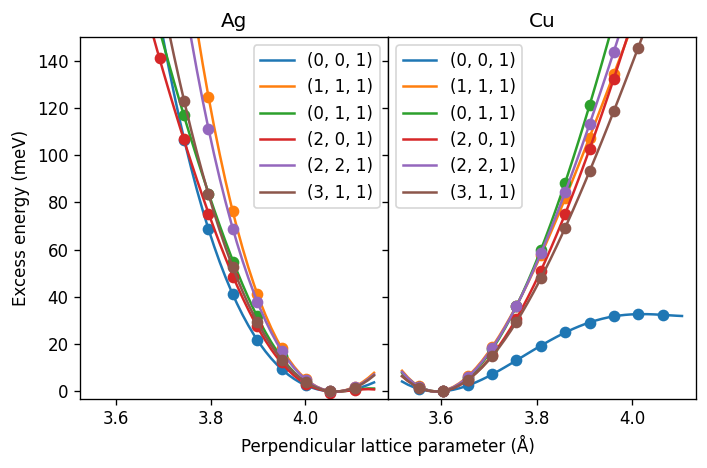

In [4]:
fig, axes = plt.subplots(
    ncols=2,
    figsize=(6, 4),
    dpi=120,
    sharey=True,
)
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# We will scale the cell perpendicular to the interface normal G
npoints = 11
scale_perps = {'Ag': np.linspace(a_calculated['Cu'] / a_calculated['Ag'], 1.01, npoints),
               'Cu': np.linspace(0.99, a_calculated['Ag'] / a_calculated['Cu'], npoints)}

# We will eventually save polynomial fits with
# energy as a function of epitaxial strain perpendicular to
# the following G vectors
Gs = [(0, 0, 1), (1, 1, 1), (0, 1, 1), (2, 0, 1), (2, 2, 1), (3, 1, 1)]
epitaxial_fits = {G: {el: [] for el in elements} for G in Gs}

for element_i, element in enumerate(elements):
    ax = axes[element_i]
    a0 = a_calculated[element]
    
    for G_i, G in enumerate(Gs):
        a_epi = []
        E_epi = []
        for scale_perp in scale_perps[element]:
            # For each "perpendicular straining", we want to find the
            # equilibrium in terms of straining in the direction parallel
            # to the interface normal.
            # These limits are arbitrary but turned out to work OK.
            scale_pars = np.linspace(1 / scale_perp**0.8 - 0.12,
                                    1 / scale_perp**0.8 + 0.12,
                                    npoints)
            energies = []
            for scale_par in scale_pars:
                structure = bulk(element, a=a0, crystalstructure='fcc')
                structure_scaled = get_scaled_atoms(structure, G=G,
                                                    scale_parallel=scale_par,
                                                    scale_perpendicular=scale_perp)
                structure_scaled.calc = calc
                energy = structure_scaled.get_potential_energy()
                energies.append(energy)
            pfit = np.polyfit(a0 * scale_pars, energies, deg=3)
            poly = np.poly1d(pfit)
            res = minimize(poly, x0=a0, bounds=[(a0 * scale_pars[0], a0 * scale_pars[-1])])
            a_epi.append(scale_perp * a0)
            E_min = poly(res.x[0])
            E_epi.append(E_min)
            
        # Now fit energy as a function of perpendicular strain
        pfit = np.polyfit(a_epi, E_epi, deg=5)
        poly = np.poly1d(pfit)
        
        # Ensure that the excess is 0 at equilibrium lattice parameter
        bounds = (min(a_epi), max(a_epi))
        res = minimize(poly, x0=np.average(bounds), bounds=[bounds])
        E_min =  poly(res.x[0])
        pfit[-1] = pfit[-1] - E_min

        epitaxial_fits[G][element] = pfit
        
        # Plot it
        scale_plot = np.linspace(0.99*min(scale_perps[element]), 1.01 * max(scale_perps[element]))
        conv = 1e3
        ax.plot(a0 * scale_plot, conv * np.poly1d(pfit)(a0 * scale_plot), label=G, color=colors[G_i])
        ax.plot(a_epi, conv * (np.array(E_epi) - E_min), 'o', color=colors[G_i])

    ax.set_title(element)
    ax.set_ylim([conv * -0.003, conv * 0.15])
    ax.legend()

axes[0].set_xlabel('Perpendicular lattice parameter (Å)', x=1)
axes[0].set_ylabel('Excess energy (meV)')

fig.tight_layout()
fig.subplots_adjust(wspace=0)

## Fit energy as a function of concentration using Redlich-Kister polynomials

In [5]:
def E_CS(a, x, epitaxials):
    """
    Returns energy of linear combination of phases
    epitaxially strained to lattice constant a.
    """
    return (1 - x) * np.poly1d(epitaxials['Ag'])(a) + x * np.poly1d(epitaxials['Cu'])(a)

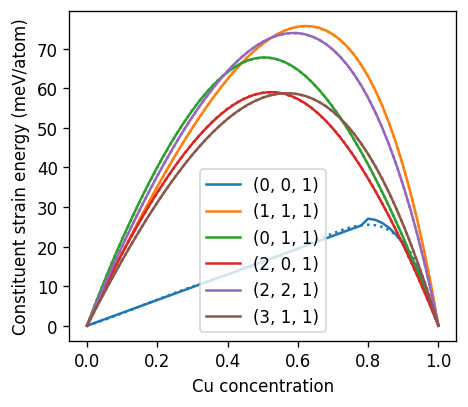

In [6]:
fig, ax = plt.subplots(
    figsize=(4, 3.5),
    dpi=120,
)

# Prepare a file to store R-K coefficents.
f = open('constituent-strain-RK-parameters.data', 'w')
f.write('# Col 1-3: G vector\n')
f.write('# Col 4-: Redlich-Kister coefficients\n')

concentrations = np.linspace(0, 1, 51)

for G_i, G in enumerate(epitaxial_fits):
    E_CS_eq = []
    for c in concentrations:
        # For each G and concentration, find the minimum energy by
        # minimizing over perpendicular lattice constant
        guess = c * a_calculated['Cu'] + (1 - c) * a_calculated['Ag']
        res = minimize(E_CS, x0=guess, args=(c, epitaxial_fits[G]),
                       bounds=[(a_calculated['Cu'], a_calculated['Ag'])])
        E_min = E_CS(res.x[0], c, epitaxial_fits[G])
        E_CS_eq.append(E_min)

    # Fit Redlich-Kister polynomial to the resulting minimizing energies
    L, _ = curve_fit(redlich_kister_vector, np.array(concentrations),
                     np.array(E_CS_eq).ravel(), p0=[1.0] * 5)
    
    # Write results for this G to file
    f.write('{:2d} {:2d} {:2d} '.format(*G))
    for l in L:
        f.write(' {:15.9f}'.format(l))
    f.write('\n')
    
    # Plot
    conv = 1e3
    ax.plot(concentrations, conv * np.array(E_CS_eq), label=G, color=colors[G_i])
    ax.plot(concentrations, conv * redlich_kister_vector(concentrations, *L), ':', color=colors[G_i])

f.close()
    
ax.legend()
ax.set_xlabel('Cu concentration')
ax.set_ylabel('Constituent strain energy (meV/atom)')

fig.tight_layout()
fig.subplots_adjust(wspace=0)

In [7]:
def _fit_cs_functions(cs_functions):
    """
    Make a polynomial fit of Redlich-Kister parameters on the
    stereographic projection of the first Brillouin zone of FCC.
    """
    A = []
    y = []
    for orientation, parameters in cs_functions.items():
        projection = _get_projection(orientation)
        A.append(_get_xy_vector(*projection))
        y.append(parameters)

    rk_fit, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
    return rk_fit


def _get_projection(orientation):
    """
    Stereographic projection of the orientation of an interface.
    Assumes cubic symmetry.
    """
    orientation = np.array(sorted(np.abs(orientation)))
    orientation = orientation / np.linalg.norm(orientation)
    return orientation[:2]


def _get_xy_vector(x, y, deg=2):
    """
    2D polynomial of degree `deg`
    """
    vector = []
    for i, j in itertools.product(range(deg + 1), repeat=2):
        if i + j > deg:
            continue
        vector.append(x**i * y**j)
    return vector


def k_to_parameter_function(k, cs_fitted_rk_parameters):
    """
    Calculate strain energy at a specific concentration and k point
    using constitutent_strain_functions as fitted with
    _fit_cs_parameters.
    """
    projection = _get_projection(k)
    vector = _get_xy_vector(*projection)
    parameters = np.dot(vector, cs_fitted_rk_parameters)
    return parameters

# Define functions for converting k point and concentration to strain
def my_k_to_parameter_function(k): return k_to_parameter_function(k, cs_fitted_rk_parameters)
def my_strain_energy_function(parameters, c): return redlich_kister(c, *parameters)